# Imports and Setup

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import pandas as pd

from getdist import plots, loadMCSamples

from plot_style import style_dict
from theory_models import load_polynomial_alpha_attractor_line
import sympy as sp
import seaborn as sns

In [2]:
chain_files = {
    # Chains for publication
    "SPA_BK": "chains/SPA_BK/CLASS",
    "SPA_BK_DESI": "chains/SPA_BK_DESI/CLASS",
    # Thinned chains for online app
    #"SPA_BK": "chains/SPA_BK_streamlit/CLASS",
    #"SPA_BK_DESI": "chains/SPA_BK_DESI_streamlit/CLASS",
}

chains = {}
bf_dicts = {}
for key, value in chain_files.items():
    chains[key] = loadMCSamples(value, settings={"ignore_rows": 0.0})# Burn-in has already been removed
    bf_dicts[key] = chains[key].getParamBestFitDict()

In [3]:
# Load Symbolic Regression Results
hof_df = pd.read_csv("sr_inf_full/hall_of_fame.csv")

# Load the training data (from the full calculation in "/polynomial_alpha_attractor_lines")
K_VALUES = [1, 2, 3, 4]
N_STAR_RANGE = np.arange(40, 66)

# Store all data
all_data_3d = {}

for k in K_VALUES:
    beta = 2 * (k + 1) / (k + 2)
    ns_offsets = 1 - beta / N_STAR_RANGE
    
    ns_raw = np.array([load_polynomial_alpha_attractor_line(N, k)[0] for N in N_STAR_RANGE])
    r_raw = np.array([load_polynomial_alpha_attractor_line(N, k)[1] for N in N_STAR_RANGE])
    ns_shifted = np.array([ns_raw[i] - ns_offsets[i] for i in range(len(N_STAR_RANGE))])
    
    all_data_3d[k] = {
        'r': r_raw,
        'ns_raw': ns_raw,
        'ns_shifted': ns_shifted,
        'ns_offset': ns_offsets,
        'beta': beta
    }


# Pick an Expression, Check Performance

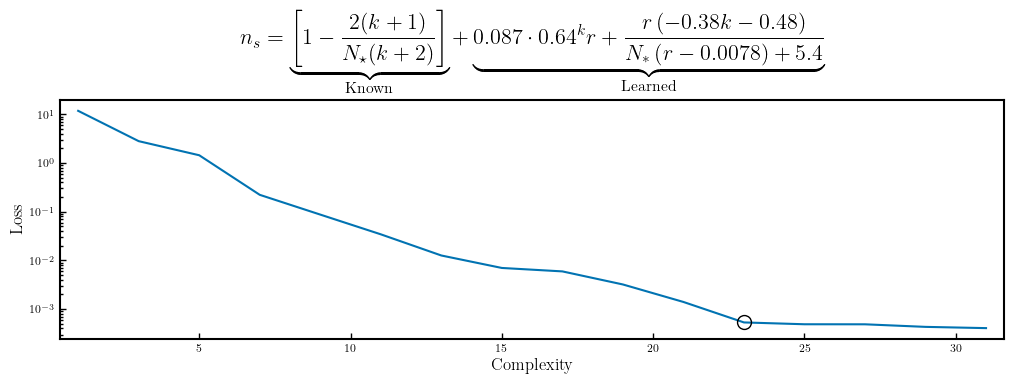

In [4]:
# Plot complexity vs loss (Pareto front)
plt.close()

# Which equation to show
# The one with complexity 23 seems to be a good trade-off between accuracy and complexity, but you can try all the others too
show_complexity = 23

fig, ax = plt.subplots(figsize=(3.414*3, 1.2*3.414))

ax.plot(hof_df['Complexity'], hof_df['Loss'])

if show_complexity>0:
    ix = np.argmin(np.abs(hof_df['Complexity']-show_complexity))
    ax.plot(hof_df['Complexity'][ix], hof_df['Loss'][ix], "ko", ms=10, markerfacecolor="none")
    
    # Grab the Equation (replace variables so it's more interpretable)
    eq_str = hof_df['Equation'][ix]
    expr = sp.sympify(eq_str)
    r_sym, N_sym, k_sym = sp.symbols("r N_* k")
    x0, x1, x2 = sp.symbols("x0 x1 x2")
    expr_nice = expr.subs([(x0, r_sym), (x1, N_sym), (x2, k_sym)])

    # Add the title to the plot
    expr_nice_latex = sp.latex(expr_nice.evalf(2))
    title_start = "$n_s = \\underbrace{{\\left[1-\\frac{{2(k+1)}}{{N_\star (k+2)}}\\right]}}_\\text{{Known}} +"
    if expr_nice_latex[0] == "-":
        expr_nice_latex = expr_nice_latex[1:]
        title_start = title_start[:-1] + "-"
    ax.set_title(f"{title_start} \\underbrace{{{expr_nice_latex}}}_\\text{{Learned}}$", fontsize=16, y=1.2)

ax.set_xlabel('Complexity', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_yscale("log")

plt.tight_layout()
plt.show()

In [5]:
# Create a prediction function from the chosen equation
ix = np.argmin(np.abs(hof_df['Complexity']-show_complexity))
best_eq_str = hof_df.loc[ix,'Equation']
expr_best = sp.sympify(best_eq_str)

# Convert to a numpy-evaluable function
x0, x1, x2 = sp.symbols("x0 x1 x2")
predict_3d_func = sp.lambdify((x0, x1, x2), expr_best, modules='numpy')

def predict_ns_shifted(r, N_star, k):
    """Predict ns_shifted = ns - ns_offset using the best symbolic equation."""
    return predict_3d_func(r, N_star, k)

def known_ns_limit(N_star, k):
    """Known limit for n_s as r-> 0"""
    return 1-2*(k+1)/(N_star*(k+2))

def ns_prediction(r, N_star, k):
    """Full prediction, combination of known and learned equation."""
    return predict_ns_shifted(r, N_star, k)+known_ns_limit(N_star, k)

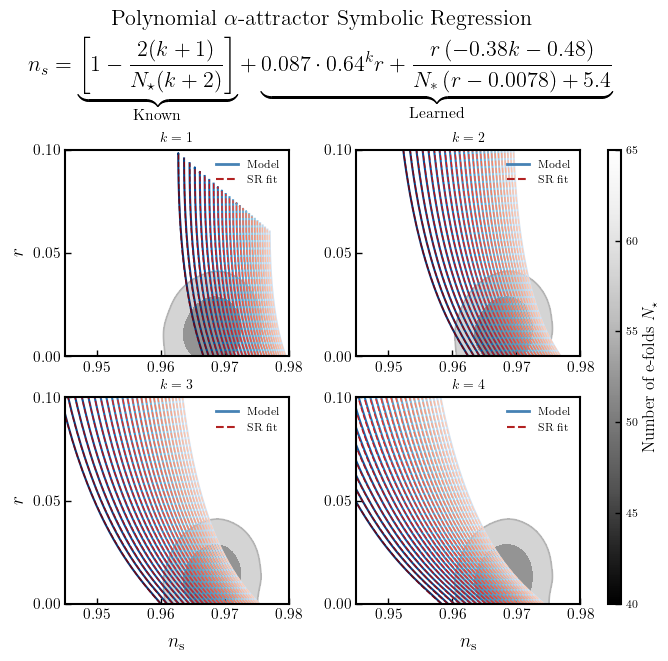

In [6]:
# Show prediction along with full calculation and data constraints

g = plots.get_single_plotter()
plt.close()
fig, axes = plt.subplots(2, 2, figsize=(3.414*2, 2*3.414), gridspec_kw={"wspace": 0.3})

for i, k in enumerate(K_VALUES):

    ax_i = int(np.floor(i/2))
    ax_j = i-ax_i*2
    ax_fit = axes[ax_i,ax_j]
    
    blues = sns.color_palette("Blues", n_colors=int(1.2*len(N_STAR_RANGE)))[::-1]
    reds = sns.color_palette("Reds", n_colors=int(1.2*len(N_STAR_RANGE)))[::-1]
    
    # Add SPA+BK data constraints using getdist
    g.plot_2d([chains["SPA_BK"]], ["n_s", "r"], 
              colors=[sns.color_palette()[-3]],#[style_dict["SPA_BK"]["colour"]],
              ls=[style_dict["SPA_BK"]["ls"]],
              lws=[style_dict["SPA_BK"]["lw"]],
              filled=[style_dict["SPA_BK"]["filled"]],
              ax=ax_fit)
    
    for i, N_test in enumerate(N_STAR_RANGE):
        r_vals = all_data_3d[k]['r'][i]
        ns_raw = all_data_3d[k]['ns_raw'][i]
        
        # Full calculation (loaded from disk)
        ax_fit.plot(ns_raw, r_vals, ls="-", lw=1.5, color=blues[i])
        
        # Prediction from symbolic regression
        ns_full_pred = ns_prediction(r_vals, N_test, k)
        ax_fit.plot(ns_full_pred, r_vals, ls="--", lw=1, color=reds[i])

    # Left panel styling
    ax_fit.plot([], [], ls="-", lw=2, color="steelblue", label="Model")
    ax_fit.plot([], [], ls="--", lw=1.5, color="firebrick", label="SR fit")
    ax_fit.legend(loc="upper right", fontsize=8)
    if ax_i == 0:
        ax_fit.set_xlabel("")
    if ax_j != 0:
        ax_fit.set_ylabel("")
    else:
        ax_fit.set_ylabel("$r$")
    ax_fit.set_title(f"$k = {k}$", fontsize=10)
    ax_fit.set_xlim((0.945, 0.98))
    ax_fit.set_ylim((0, 0.1))

# Equation
expr = sp.sympify(best_eq_str)
r_sym, N_sym, k_sym = sp.symbols("r N_* k")
x0, x1, x2 = sp.symbols("x0 x1 x2")
expr_nice = expr.subs([(x0, r_sym), (x1, N_sym), (x2, k_sym)])

# Add colorbar spanning both rows on the right
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.775-0.11])  # [left, bottom, width, height]
sm = ScalarMappable(cmap="Greys_r", norm=Normalize(vmin=np.amin(N_STAR_RANGE), vmax=np.amax(N_STAR_RANGE)))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Number of e-folds $N_\\star$', fontsize=12)

# Add the title to the plot
expr_nice_latex = sp.latex(expr_nice.evalf(2))
title_start = "$n_s = \\underbrace{{\\left[1-\\frac{{2(k+1)}}{{N_\star (k+2)}}\\right]}}_\\text{{Known}} +"
if expr_nice_latex[0] == "-":
    expr_nice_latex = expr_nice_latex[2:]
    title_start = title_start[:-1] + "-"

plt.suptitle(f"Polynomial $\\alpha$-attractor Symbolic Regression \n{title_start} \\underbrace{{{expr_nice_latex}}}_\\text{{Learned}}$", fontsize=16)

plt.subplots_adjust(top=0.775, right=0.88)
#plt.tight_layout()
plt.show()

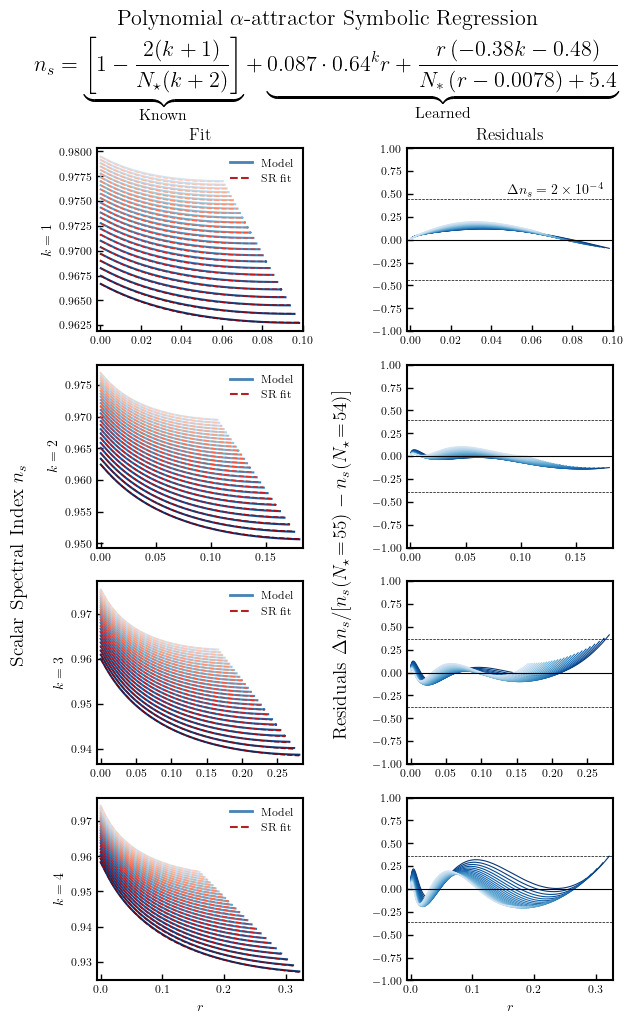

In [7]:
# Visualize fit quality: 4 rows (k=1-4), 2 columns (model+fit, residuals)

plt.close()
fig, axes = plt.subplots(4, 2, figsize=(3.464*2, 3.464*3))

for row, k in enumerate(K_VALUES):
    ax_fit = axes[row, 0]
    ax_res = axes[row, 1]
    
    blues = sns.color_palette("Blues", n_colors=int(1.2*len(N_STAR_RANGE)))[::-1]
    reds = sns.color_palette("Reds", n_colors=int(1.2*len(N_STAR_RANGE)))[::-1]
    
    for i, N_test in enumerate(N_STAR_RANGE):
        r_vals = all_data_3d[k]['r'][i]
        ns_raw = all_data_3d[k]['ns_raw'][i]
        
        # Full calculation (loaded from disk)
        ax_fit.plot(r_vals, ns_raw, ls="-", lw=1.5, color=blues[i])
        
        # Prediction from symbolic regression
        ns_full_pred = ns_prediction(r_vals, N_test, k)
        ax_fit.plot(r_vals, ns_full_pred, ls="--", lw=1, color=reds[i])
        
        # Residuals
        beta = 2*(k+1)/(k+2)
        delta_ns = np.abs((1-beta/55)-(1-beta/54))# scale for the residuals - change by 1 in e-folds

        scale = delta_ns
        residual = (ns_raw - ns_full_pred) / scale
        ax_res.plot(r_vals, residual, color=blues[i], ls="-", lw=0.8)
    
    # Left panel styling
    ax_fit.plot([], [], ls="-", lw=2, color="steelblue", label="Model")
    ax_fit.plot([], [], ls="--", lw=1.5, color="firebrick", label="SR fit")
    ax_fit.legend(loc="upper right", fontsize=8)
    ax_fit.set_ylabel(f"$k = {k}$")
    ax_fit.set_ylabel(f"$k = {k}$")
    
    # Right panel styling
    ax_res.axhline(0, color="k", ls="-", lw=0.8)
    ax_res.axhline(2e-4/scale, color="k", ls="--", lw=0.5)
    ax_res.axhline(-2e-4/scale, color="k", ls="--", lw=0.5)

    if row == 0:
        ax_res.text(0.095,
                    0.11*2e-3/scale,
                    "$\Delta n_s=2\\times 10^{-4}$",
                    ha="right")

    ax_res.set_ylim((-1.0, 1.0))
    
    # Only show x-labels on bottom row
    if row == len(K_VALUES) - 1:
        ax_fit.set_xlabel("$r$")
        ax_res.set_xlabel("$r$")
    
    if row == 0:
        ax_fit.set_title("Fit")
        ax_res.set_title("Residuals")

# Finish plot with axes labels and the title

# Left supylabel using dummy axes trick (spans left half)
ax_dummy_left = fig.add_subplot(1, 2, 1)
ax_dummy_left.set_xticks([])
ax_dummy_left.set_yticks([])
[ax_dummy_left.spines[side].set_visible(False) for side in ('left', 'top', 'right', 'bottom')]
ax_dummy_left.patch.set_visible(False)
ax_dummy_left.yaxis.set_label_position('left')
ax_dummy_left.set_ylabel('Scalar Spectral Index $n_s$', labelpad=50, fontsize=14)

# Right supylabel using dummy axes trick (spans right half, label on left side = between columns)
ax_dummy_right = fig.add_subplot(1, 2, 2)
ax_dummy_right.set_xticks([])
ax_dummy_right.set_yticks([])
[ax_dummy_right.spines[side].set_visible(False) for side in ('left', 'top', 'right', 'bottom')]
ax_dummy_right.patch.set_visible(False)
ax_dummy_right.yaxis.set_label_position('left')
ax_dummy_right.set_ylabel('Residuals $\Delta n_s / [n_s(N_\star\!=\!55)-n_s(N_\star\!=\!54)]$', labelpad=40, fontsize=14)

# Add the title to the plot
expr_nice_latex = sp.latex(expr_nice.evalf(2))
title_start = "$n_s = \\underbrace{{\\left[1-\\frac{{2(k+1)}}{{N_\star (k+2)}}\\right]}}_\\text{{Known}} +"
if expr_nice_latex[0] == "-":
    expr_nice_latex = expr_nice_latex[2:]
    title_start = title_start[:-1] + "-"
plt.suptitle(f"Polynomial $\\alpha$-attractor Symbolic Regression \n{title_start} \\underbrace{{{expr_nice_latex}}}_\\text{{Learned}}$", fontsize=16, x=0.55)

plt.tight_layout()
plt.subplots_adjust(wspace=0.5)  # Reduce horizontal space between columns
plt.show()